# Red Giant Mode fitting

Fitting $nstars$ RG stars chosen at random.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import random

In [2]:
#import output data
nstars = 50
IDs = []
stardat = pd.read_csv('RGdata/output_1000stars.csv', delim_whitespace=False, header=0, usecols=range(1,4))
for i in range(nstars):
    IDs.append(random.choice(stardat['ID']))

modes = {} # dictionary with frequencies and errors
for i in IDs:
    modes[str(i)] = pd.read_csv('RGdata/modes_'+str(i)+'.csv', delim_whitespace=False, header=0, usecols=[0,7])
    modes[str(i)] = modes[str(i)].sort_values(by=['f0'])
    modes[str(i)] = modes[str(i)].set_index(np.arange(0,len(modes[str(i)]),1))
    modes[str(i)]['dnu'] = modes[str(i)].f0.diff(2).shift(-1)/2
    dnu_avg = np.mean(modes[str(i)].dnu)
    n_min = int(modes[str(i)].f0.min() / dnu_avg)
    n_obs = np.arange(n_min, n_min+len(modes[str(i)].f0), 1)
    modes[str(i)]['n'] = n_obs
    
stardat= stardat.loc[stardat['ID'].isin(IDs)]

To find a ballpark figure before defining priors, will use model:

$$\nu(n)=(n+\epsilon)\langle\Delta\nu\rangle+k(n_{max}-n)^2+\mathcal{A}e^{-n/\tau}sin(nw+\phi)$$

where $n_{max}= \nu_{max}/\Delta\nu - \epsilon$

In [3]:
def echelle(stardat, modes, ID, model=False, stanfit=[], stan_dnu=0):
    numax_obs = float(stardat.loc[stardat['ID'] == ID].Numax)
    numax_obs_err = float(stardat.loc[stardat['ID'] == ID].Numax_err)
    #dnu_obs = float(stardat.loc[stardat.ID == IDs[i]].Dnu_median_all)
    #dnu_obs = np.mean(np.diff(modes[str(IDs[i])].f0)) 
    dnu_obs = np.mean(modes[str(ID)].f0.diff(2).shift(-1)/2)
    # Create dataframes for frequencies and calculate orders n
    l0modes = pd.DataFrame([modes[str(ID)].f0, modes[str(ID)].f0_err])
    l0modes = l0modes.T
    l0modes = l0modes.sort_values('f0', ascending=True)
    n_min = int(l0modes.f0.min() / dnu_obs)
    n_obs = np.arange(n_min, n_min+len(l0modes.f0), 1)
    l0modes['n'] = n_obs
    l0modes = l0modes.set_index(np.arange(0, len(l0modes.f0), 1))
    plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = str(ID))
    
    if model:
        label = 'Stan Fit'+str(ID)
        plt.plot(stanfit % stan_dnu, stanfit, label = label)


In [4]:
def model(n, dnu, nmax, epsilon, k, A, w, tau, phi):
    freqs = (n + epsilon) * dnu + k * (nmax - n)**2 + A * np.exp(-n/tau) * np.sin(n * w + phi);
    return freqs

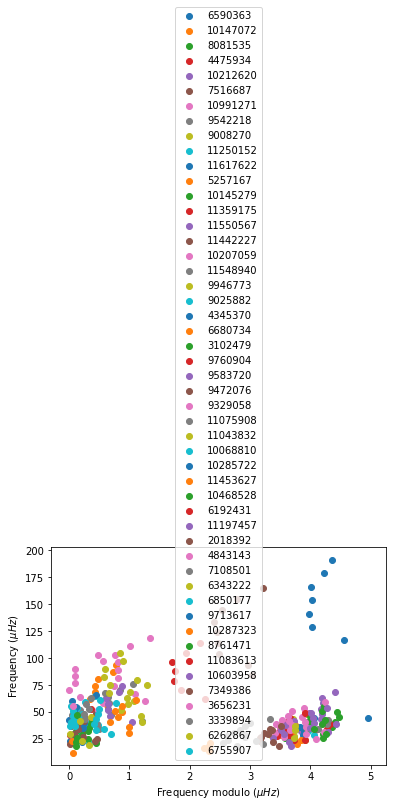

In [5]:
for i in IDs:   
    echelle(stardat, modes, i)
    
    '''n = l0modes.n
    epsilon = 0.4
    nmax = numax_obs/dnu_obs - epsilon
    k = 0.1
    A = 0.2
    w = 3
    tau = 8
    phi = 0
    f = model(n, dnu_obs, nmax, epsilon, k, A, w, tau, phi)
    plt.plot(f % dnu_obs, f, label = str(IDs[i])+'model')'''
    

plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
plt.legend()
#plt.xlim(3.0, dnu_obs)

In [68]:
'''plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = 'Data') 
plt.plot(f % dnu_obs, f, label = 'Model')
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
#mod_err = (l0modes.f0 % dnu_obs)*np.sqrt((dnu_obs_err/dnu_obs)**2 + (l0modes.f0_err/l0modes.f0)**2)
plt.errorbar(l0modes.f0 % dnu_obs, l0modes.f0, yerr = l0modes.f0_err, xerr = mod_err, ecolor = 'r', ls='none', label = 'Error')
plt.legend()'''

"plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = 'Data') \nplt.plot(f % dnu_obs, f, label = 'Model')\nplt.xlabel(r'Frequency modulo ($\\mu Hz$)')\nplt.ylabel(r'Frequency ($\\mu Hz$)')\n#mod_err = (l0modes.f0 % dnu_obs)*np.sqrt((dnu_obs_err/dnu_obs)**2 + (l0modes.f0_err/l0modes.f0)**2)\nplt.errorbar(l0modes.f0 % dnu_obs, l0modes.f0, yerr = l0modes.f0_err, xerr = mod_err, ecolor = 'r', ls='none', label = 'Error')\nplt.legend()"

In [6]:
code = '''
data {
    int N;
    real n[N];
    real freq[N];
    real freq_err[N];
    real dnu_guess;
}
parameters {
    real dnu;
    real epsilon;
    real nmax;
    real k;
    real<lower = 0> A;
    real<lower = 0, upper = 1.5> w;
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi;
    real<lower = 0> tau;
}
model {
    real mod[N];
    for (i in 1:N){
        mod[i] = (n[i] + epsilon) * dnu + k * (nmax - n[i])^2 + 
            A * exp(-n[i]/tau) * sin(n[i] * w + phi);
    }
    mod ~ normal(freq, freq_err);
    dnu ~ normal(dnu_guess, dnu_guess*0.001);
    epsilon ~ normal(1.0, 0.3);
    epsilon ~ uniform(-1.0, 2.0);
    nmax ~ normal(20, 4);
    k ~ lognormal(log(0.1), 0.3);
    A ~ lognormal(log(1), 0.4);
    w ~ normal(0.8, 0.1);
    tau ~ normal(50, 10);
}
generated quantities{
    real fm[N];
    for (j in 1:N){
        fm[j] = (n[j] + epsilon) * dnu + k * (nmax - n[j])^2 + 
            A * exp(-n[j]/tau) * sin(n[j] * w + phi);
    }
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9c447c93b58b94cf47f14613c64c8a71 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpv8rqoxf4/stanfit4anon_model_9c447c93b58b94cf47f14613c64c8a71_8776892106234805392.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [7]:
fits = {}
for i in IDs:
    dat_star = stardat.loc[stardat['ID'] == i]
    df_star = modes[str(i)]
    df_star = df_star.sort_values(by=['f0'])
    dnu_obs = np.mean(df_star.dnu)
    numax_obs = float(dat_star.loc[dat_star['ID'] == i].Numax)
    df_star = df_star.set_index(np.arange(0, len(df_star.f0), 1))
    nmax_guess = np.mean(df_star.n)
    epsilon_obs = np.median((df_star.f0 % dnu_obs) / dnu_obs)
    
    data = {'N': len(df_star.f0), 'n': df_star.n.values, 'freq': df_star.f0.values,
            'freq_err': df_star.f0_err.values, 'dnu_guess': dnu_obs}
    start = {'dnu': dnu_obs, 'epsilon': epsilon_obs, 
             'nmax': numax_obs/dnu_obs - epsilon_obs, 'k': 0.1, 'A': 1.0,
             'w': 0.8, 'phi': 2.0, 'tau': 50}
    nchains=4
    fit = sm.sampling(data=data, iter=5000, chains=nchains, init=[start for n in range(nchains)])
    fits[str(i)] = fit
    output = pd.DataFrame({'dnu': fit['dnu'], 'nmax': fit['nmax'], 'epsilon': fit['epsilon'], 
                           'k': fit['k'], 'A': fit['A'], 'w': fit['w'], 'phi': fit['phi'], 'tau': fit['tau']})
    #output.to_csv('samples_' + str(i) + '.csv')

In [8]:
for i in IDs:
    print('ID = ' + str(i))
    print(fits[str(i)])

ID = 6590363
Inference for Stan model: anon_model_9c447c93b58b94cf47f14613c64c8a71.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       3.63  4.0e-5 3.7e-3   3.62   3.63   3.63   3.63   3.64   8478    1.0
epsilon  -0.12  7.6e-4   0.03   -0.2  -0.14  -0.12  -0.09  -0.06   2090    1.0
nmax      9.34  5.2e-3   0.26   8.97   9.17    9.3   9.47   9.98   2491    1.0
k         0.08  3.2e-4   0.02   0.06   0.07   0.08   0.09   0.12   2504    1.0
A          0.5  3.3e-3   0.15   0.27   0.39   0.48   0.59   0.86   2156    1.0
w         0.64  1.5e-3   0.08   0.49   0.59   0.64    0.7    0.8   2646    1.0
phi        1.7    0.01   0.66   0.38   1.26   1.72   2.15   2.96   2791    1.0
tau       47.8    0.13  10.35  27.37  40.91  47.94  54.67  67.96   6126    1.0
fm[1]    22.01  4.2e-4   0.04  21.93  21.99  22.01  22.04  22.09   9468    1.0
fm[2]  

Inference for Stan model: anon_model_9c447c93b58b94cf47f14613c64c8a71.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.09  4.7e-5 4.1e-3   4.08   4.09   4.09   4.09    4.1   7534    1.0
epsilon  -0.06  6.3e-4   0.03  -0.13  -0.08  -0.06  -0.04  -0.01   2304    1.0
nmax      9.17  3.0e-3   0.17   8.91   9.05   9.14   9.25   9.58   3288    1.0
k          0.1  3.0e-4   0.02   0.07   0.09    0.1   0.11   0.13   2976    1.0
A         0.51  3.1e-3   0.14   0.28    0.4   0.49   0.59   0.84   2238    1.0
w         0.69  1.6e-3   0.08   0.54   0.64   0.69   0.75   0.85   2483    1.0
phi       1.42    0.01   0.66   0.07   0.98   1.43   1.86   2.67   2525    1.0
tau      47.75    0.14  10.55  26.57  40.81  48.04   54.8  67.97   5698    1.0
fm[1]    25.01  2.9e-4   0.03  24.95  24.99  25.01  25.03  25.06   9931    1.0
fm[2]    28.84  1.7e

Inference for Stan model: anon_model_9c447c93b58b94cf47f14613c64c8a71.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.13  5.8e-5 4.2e-3   4.13   4.13   4.13   4.14   4.14   5050    1.0
epsilon   0.78  8.6e-4   0.04    0.7   0.76   0.78    0.8   0.84   1667    1.0
nmax      6.23    0.02   0.85   4.62   5.67   6.18   6.76   8.12   1441   1.01
k          0.1  6.4e-4   0.03   0.05   0.08    0.1   0.12   0.16   1762    1.0
A         0.53  4.4e-3   0.16   0.28   0.42   0.51   0.62   0.92   1360    1.0
w         0.66  1.7e-3   0.09   0.48    0.6   0.65   0.72   0.84   2716    1.0
phi       3.77    0.02   0.77   2.35   3.23   3.73    4.3    5.3   2528    1.0
tau      48.59    0.15   10.1  28.32  41.98  48.46  55.39  68.59   4739    1.0
fm[1]    20.34  7.0e-4   0.05  20.25  20.31  20.34  20.37  20.44   4482    1.0
fm[2]    24.36  2.4e

Inference for Stan model: anon_model_9c447c93b58b94cf47f14613c64c8a71.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       7.33 10.0e-5 7.4e-3   7.32   7.33   7.33   7.34   7.35   5474    1.0
epsilon   0.07  5.9e-3   0.02   0.03   0.06   0.07   0.09    0.1     10   1.13
nmax     12.31  5.7e-3   0.28  11.89  12.11  12.27  12.45  12.96   2409   1.01
k         0.06  2.0e-3   0.01   0.04   0.05   0.06   0.07   0.08     29   1.05
A         0.38    0.05   0.13   0.21   0.29   0.35   0.42   0.76      6   1.22
w         0.65    0.03   0.07   0.47   0.63   0.66    0.7   0.79      5    1.3
phi       4.41    1.56   2.28  -0.54   2.96   5.56    6.0   6.26      2   3.71
tau      46.79    0.15  10.86  24.42  39.74  46.97  54.23   67.5   5018    1.0
fm[1]    60.03  3.7e-3   0.03  59.97  60.01  60.03  60.05  60.09     76   1.02
fm[2]     67.0  2.1e

Inference for Stan model: anon_model_9c447c93b58b94cf47f14613c64c8a71.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       2.35  2.8e-5 2.4e-3   2.35   2.35   2.35   2.36   2.36   7020    1.0
epsilon  -0.18  1.6e-3   0.05  -0.28   -0.2  -0.17  -0.14   -0.1    879   1.01
nmax      8.52  8.8e-3   0.46   7.86    8.2   8.45   8.76   9.63   2702    1.0
k         0.07  3.6e-4   0.02   0.04   0.06   0.07   0.08    0.1   1858    1.0
A         0.49  4.8e-3   0.14   0.28   0.39   0.48   0.57    0.8    799   1.01
w         0.64  1.6e-3   0.07   0.51   0.59   0.64   0.69   0.79   2184    1.0
phi      -2.54    1.94   2.79  -5.11  -4.31  -3.89  -0.98   2.82      2    5.9
tau      48.44    0.14  10.32  28.04  41.34  48.51  55.49  68.59   5460    1.0
fm[1]    11.85  2.0e-4   0.02  11.81  11.83  11.85  11.86  11.88   9363    1.0
fm[2]    14.03  1.2e

Inference for Stan model: anon_model_9c447c93b58b94cf47f14613c64c8a71.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       5.65  7.2e-5 5.5e-3   5.64   5.65   5.65   5.65   5.66   5915    1.0
epsilon   0.12    0.01   0.03   0.06   0.11   0.13   0.14   0.17      6   1.22
nmax     10.84    0.02   0.39  10.26  10.56  10.77  11.05   11.8    289   1.02
k         0.06  4.4e-3   0.01   0.03   0.05   0.06   0.07   0.09     11   1.12
A         0.44    0.06   0.18   0.19   0.29   0.41   0.54   0.87      9   1.16
w         0.58    0.06   0.11    0.4    0.5   0.57   0.66   0.78      3   1.54
phi       2.63    1.24   1.99  -0.07    1.3   1.99   3.25   6.24      3   2.09
tau      46.01    1.08   12.3  15.09  39.15  46.85  54.22   67.4    130   1.03
fm[1]    40.91  6.6e-3   0.04  40.84  40.88  40.91  40.93  40.98     30   1.05
fm[2]    46.28  2.0e

Inference for Stan model: anon_model_9c447c93b58b94cf47f14613c64c8a71.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.49  5.3e-5 4.4e-3   4.49   4.49   4.49    4.5    4.5   7055    1.0
epsilon   0.78  6.9e-4   0.03   0.71   0.76   0.78    0.8   0.83   2210    1.0
nmax      8.64  2.3e-3   0.12   8.45   8.56   8.62   8.69   8.92   2795    1.0
k         0.17  6.5e-4   0.03   0.11   0.15   0.17   0.19   0.24   2386    1.0
A         0.68  3.6e-3   0.17   0.41   0.55   0.65   0.77   1.07   2214    1.0
w         0.91  1.5e-3   0.08   0.76   0.86   0.91   0.96   1.06   2643    1.0
phi      -0.03    0.01   0.62  -1.27  -0.45  -0.03   0.39   1.15   2640    1.0
tau      48.65    0.13  10.37  28.36  41.56  48.67  55.81  69.01   6548    1.0
fm[1]    31.25  3.2e-4   0.03  31.18  31.23  31.25  31.27  31.31  10378    1.0
fm[2]    35.48  1.7e

Inference for Stan model: anon_model_9c447c93b58b94cf47f14613c64c8a71.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu      12.46  1.9e-4   0.01  12.44  12.46  12.46  12.47  12.49   4084    1.0
epsilon   0.28  2.9e-4   0.02   0.25   0.27   0.28   0.29   0.31   2931    1.0
nmax      12.0  1.2e-3   0.07  11.87  11.95   12.0  12.05  12.16   3588    1.0
k         0.16  4.0e-4   0.02   0.13   0.15   0.16   0.18   0.21   2787    1.0
A         0.65  3.5e-3   0.17   0.39   0.53   0.62   0.74   1.05   2326    1.0
w         0.87  1.4e-3   0.07   0.74   0.82   0.87   0.92   1.01   2336    1.0
phi        2.0    1.93   2.82  -3.75  -0.21   3.24   3.93   5.02      2   3.67
tau      46.57    0.16  10.86  24.31   39.3  46.57  53.98  67.48   4793    1.0
fm[1]   116.72  2.2e-4   0.02 116.68 116.71 116.72 116.74 116.77  10046    1.0
fm[2]    128.7  1.6e

Inference for Stan model: anon_model_9c447c93b58b94cf47f14613c64c8a71.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.28  6.0e-5 4.4e-3   4.27   4.27   4.28   4.28   4.29   5244    1.0
epsilon   0.75  1.4e-3   0.04   0.65   0.73   0.75   0.77    0.8    688    1.0
nmax      8.38  1.4e-3    0.1   8.19   8.31   8.38   8.45   8.59   5027    1.0
k          0.1  5.6e-4   0.02   0.07   0.09    0.1   0.11   0.14    856    1.0
A         0.57  6.4e-3   0.18   0.29   0.44   0.54   0.66   1.03    811    1.0
w         0.67  1.5e-3   0.07   0.53   0.62   0.66   0.71   0.81   2229    1.0
phi       2.43    0.01   0.58   1.27   2.05   2.44   2.83   3.53   2244    1.0
tau      49.07    0.16  10.41  28.64  42.03  49.22  56.23  68.93   4485    1.0
fm[1]    25.51  2.2e-4   0.02  25.46  25.49   25.5  25.52  25.55   8945    1.0
fm[2]    29.51  2.2e

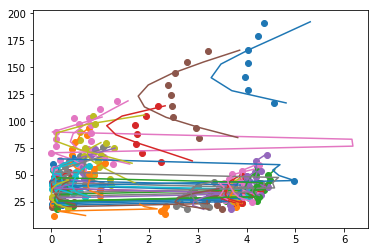

In [9]:
for i in IDs:
    stanfit = model(modes[str(i)].n, fits[str(i)]['dnu'].mean(), fits[str(i)]['nmax'].mean(), fits[str(i)]['epsilon'].mean(), fits[str(i)]['k'].mean(), fits[str(i)]['A'].mean(), fits[str(i)]['w'].mean(), fits[str(i)]['tau'].mean(), fits[str(i)]['phi'].mean())
    stan_dnu = fits[str(i)]['dnu'].mean()
    echelle(stardat, modes, i, True, stanfit, stan_dnu)